In [291]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
from pprint import pprint
import simplekml
from config import EIA_api_key
from scipy.stats import linregress


# Call the USGS turbine database API

## Add the response to a DataFrame

In [292]:
base_url="https://eersc.usgs.gov/api/uswtdb/v1/turbines"

In [293]:
response = requests.get(base_url).json()

In [294]:
df = pd.DataFrame(response)
df

,case_id,faa_ors,faa_asn,usgs_pr_id,t_state,t_county,t_fips,p_name,p_year,p_tnum,...,t_ttlh,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat,eia_id,retrofit,retrofit_year
0,3001247,None,None,5115.0,CA,Kern County,6029,251 Wind,1987.0,194,...,NaN,2,3,5/8/2018,Digital Globe,-118.36819,35.07579,52161.0,0,NaN
1,3009410,None,None,5116.0,CA,Kern County,6029,251 Wind,1987.0,194,...,NaN,2,3,5/8/2018,Digital Globe,-118.36809,35.07589,52161.0,0,NaN
2,3072670,None,None,5112.0,CA,Kern County,6029,251 Wind,1987.0,194,...,NaN,2,3,5/8/2018,Digital Globe,-118.36841,35.07554,52161.0,0,NaN
3,3072663,None,None,5114.0,CA,Kern County,6029,251 Wind,1987.0,194,...,NaN,2,3,5/8/2018,Digital Globe,-118.36820,35.07570,52161.0,0,NaN
4,3072661,None,None,5149.0,CA,Kern County,6029,251 Wind,1987.0,194,...,NaN,2,3,5/8/2018,Digital Globe,-118.36376,35.07791,52161.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68787,3108971,None,2020-WTW-3724-OE,NaN,TX,Zapata County,48505,unknown Zapata County,2021.0,41,...,NaN,1,3,2/6/2021,Digital Globe,-99.29768,27.09550,NaN,0,NaN
68788,3109386,None,2020-WTW-3723-OE,NaN,TX,Zapata County,48505,unknown Zapata County,2020.0,41,...,NaN,1,3,2/6/2021,Digital Globe,-99.28698,27.09672,NaN,0,NaN
68789,3106411,48-174404,2019-WTW-10988-OE,NaN,TX,Zapata County,48505,unknown Zapata County,2020.0,41,...,NaN,1,3,2/6/2021,Digital Globe,-99.28335,27.15668,NaN,0,NaN
68790,3109758,None,2019-WTW-10984-OE,NaN,TX,Zapata County,48505,unknown Zapata County,2020.0,41,...,NaN,1,3,2/6/2021,Digital Globe,-99.32201,27.12558,NaN,0,NaN


# Remove irrelevant columns for analysis

In [295]:
df.keys()

Index(['case_id', 'faa_ors', 'faa_asn', 'usgs_pr_id', 't_state', 't_county',
       't_fips', 'p_name', 'p_year', 'p_tnum', 'p_cap', 't_manu', 't_model',
       't_cap', 't_hh', 't_rd', 't_rsa', 't_ttlh', 't_conf_atr', 't_conf_loc',
       't_img_date', 't_img_srce', 'xlong', 'ylat', 'eia_id', 'retrofit',
       'retrofit_year'],
      dtype='object')

In [296]:
df = df.drop(columns=['case_id','faa_ors','faa_asn','usgs_pr_id','t_fips','t_rsa','t_cap','t_ttlh','t_conf_atr', 't_conf_loc','t_img_date', 't_img_srce','eia_id', 'retrofit','retrofit_year'])

In [297]:
df = df.rename(columns={'t_state':'State','t_county':'County','p_name':'Wind Farm Name','p_year': 'Year',
                       'p_tnum':'Turbine Count','p_cap':'WF Total MW','t_manu':'Turbine Manufacturer',
                       't_model':'Turbine Model','t_hh': 'Turbine Hub Height','t_rd':'Rotor Diameter','xlong':'lng','ylat':'lat'})

In [298]:
df

,State,County,Wind Farm Name,Year,Turbine Count,WF Total MW,Turbine Manufacturer,Turbine Model,Turbine Hub Height,Rotor Diameter,lng,lat
0,CA,Kern County,251 Wind,1987.0,194,18.43,Vestas,None,NaN,NaN,-118.36819,35.07579
1,CA,Kern County,251 Wind,1987.0,194,18.43,Vestas,None,NaN,NaN,-118.36809,35.07589
2,CA,Kern County,251 Wind,1987.0,194,18.43,Vestas,None,NaN,NaN,-118.36841,35.07554
3,CA,Kern County,251 Wind,1987.0,194,18.43,Vestas,None,NaN,NaN,-118.36820,35.07570
4,CA,Kern County,251 Wind,1987.0,194,18.43,Vestas,None,NaN,NaN,-118.36376,35.07791
...,...,...,...,...,...,...,...,...,...,...,...,...
68787,TX,Zapata County,unknown Zapata County,2021.0,41,NaN,None,None,NaN,NaN,-99.29768,27.09550
68788,TX,Zapata County,unknown Zapata County,2020.0,41,NaN,None,None,NaN,NaN,-99.28698,27.09672
68789,TX,Zapata County,unknown Zapata County,2020.0,41,NaN,None,None,NaN,NaN,-99.28335,27.15668
68790,TX,Zapata County,unknown Zapata County,2020.0,41,NaN,None,None,NaN,NaN,-99.32201,27.12558


In [299]:
#Clean data frame for wind farms built from 2000 forward
modern_WF = df.loc[df['Year']>=2000.0]
modern_WF =modern_WF.reset_index(drop=True)
len(modern_WF['Wind Farm Name'].unique())

1574

In [300]:
#Clean unkown wind farm
duplicate_df=modern_WF.duplicated('Wind Farm Name')
modern_WF['Duplicated']=duplicate_df.values
index_value = modern_WF[modern_WF['Duplicated']==True].index

modern_WF_clean = modern_WF.drop(index=modern_WF.index[index_value])

In [301]:
#drop NA Total MW
modern_WF_MW = modern_WF_clean.dropna(subset=['WF Total MW'])

# Save the wind farms to a kml file

In [302]:
kml = simplekml.Kml()
modern_WF_MW.apply(lambda X: kml.newpoint(name=X["Wind Farm Name"], coords=[( X["lng"],X["lat"])]) ,axis=1)
kml.save("WF_US.kml")

# Plot wind farm installed capacity trends

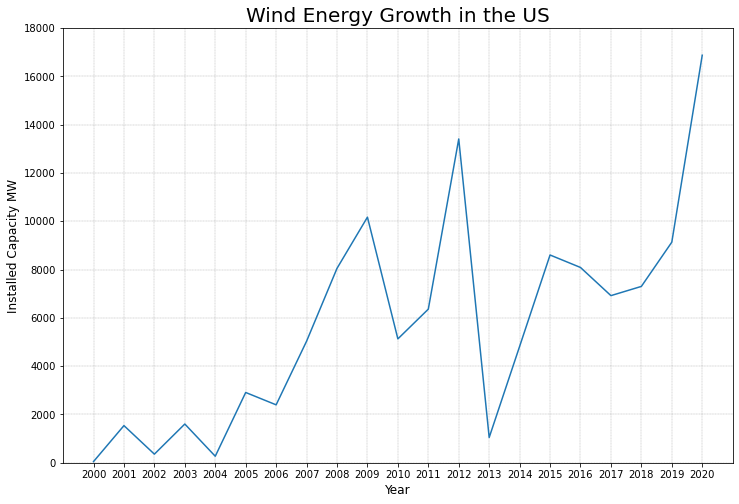

In [303]:
#INCLUDE IN BEGINNING OF PRESENTATION

WF_year = modern_WF_MW.groupby('Year')
MW_year = WF_year['WF Total MW'].sum()
x = MW_year.index
y = MW_year.values
plt.subplots(figsize=(12, 8))
plt.plot(x,y)
plt.xlabel('Year',fontsize=12)
plt.ylabel('Installed Capacity MW',fontsize=12)
plt.title('Wind Energy Growth in the US',fontsize=20)
plt.ylim(0,18000)
plt.grid(color='grey', linestyle='--', linewidth=0.3)
plt.xticks(range(2000,2021))
plt.show()

# Plot wind farm installed capacity by state

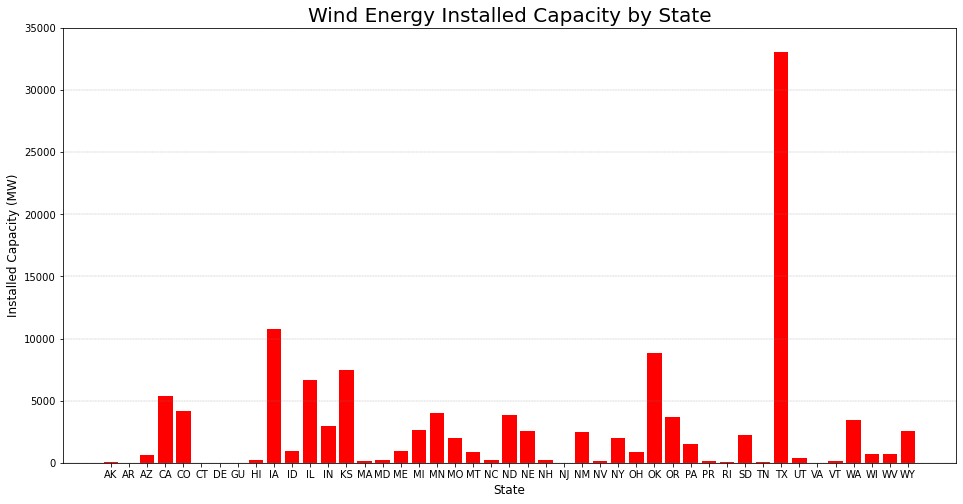

In [304]:
# INCLUDE IN BEGINNING OF PRESENTATION - SHOWING HOW WE DECIDED ON THE FOUR STATES WE USED FOR FURTHER ANALYSIS

WF_state = modern_WF_MW.groupby('State')
WF_state_MW = WF_state['WF Total MW'].sum()
x = WF_state_MW.index
y = WF_state_MW.values
plt.subplots(figsize=(16, 8))
plt.bar(x,y,color='r')
plt.xlabel('State',fontsize=12)
plt.ylabel('Installed Capacity (MW)',fontsize=12)
plt.title('Wind Energy Installed Capacity by State',fontsize=20)
plt.ylim(0,35000)
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.3)
plt.show()

# Average turbine height trends

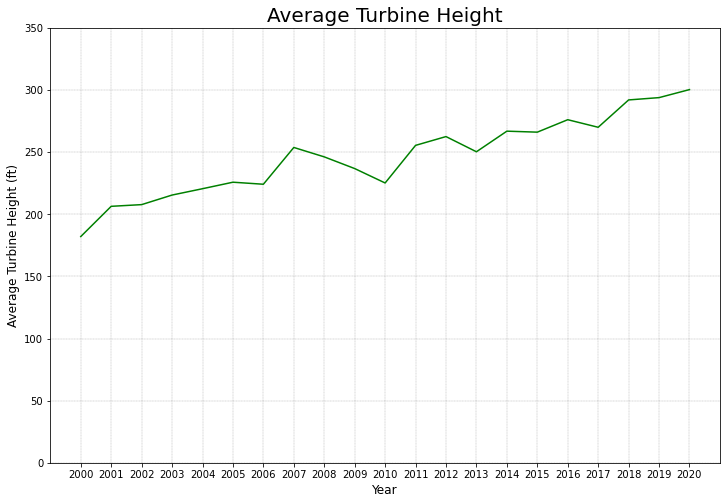

In [305]:
# THESE GRAPHS COULD BE USED IN PRESENTATION TO SHOW HOW WIND TURBINES ARE BECOMING MORE POWERFUL OVER TIME
# BUT THEY AREN'T COMPLETELY NECESSARY TO BE USED

height_year = modern_WF_MW.groupby('Year')
height_year = (height_year['Turbine Hub Height'].mean()) * 3.28084
x = height_year.index
y = height_year.values
plt.subplots(figsize=(12, 8))
plt.plot(x,y,color='g')
plt.xlabel('Year',fontsize=12)
plt.ylabel('Average Turbine Height (ft)',fontsize=12)
plt.title('Average Turbine Height',fontsize=20)
plt.ylim(0,350)
plt.grid(color='grey', linestyle='--', linewidth=0.3)
plt.xticks(range(2000,2021))
plt.show()

# Average rotor diameter trends

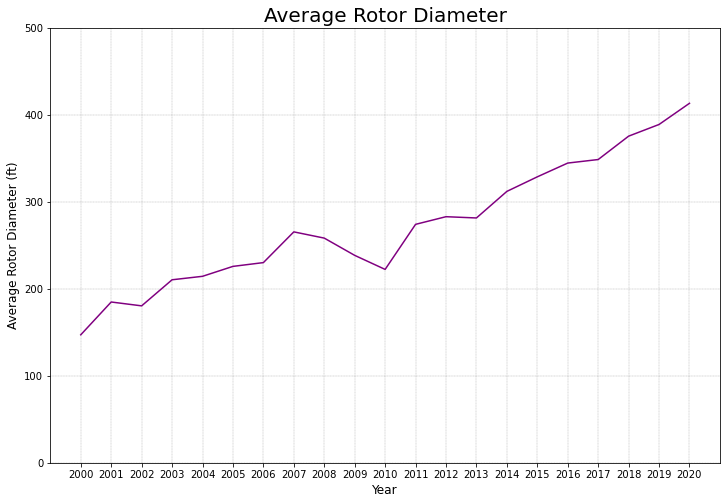

In [306]:
# THESE GRAPHS COULD BE USED IN PRESENTATION TO SHOW HOW WIND TURBINES ARE BECOMING MORE POWERFUL OVER TIME
# BUT THEY AREN'T COMPLETELY NECESSARY TO BE USED

diameter_year = modern_WF_MW.groupby('Year')
diameter_year = (diameter_year['Rotor Diameter'].mean()) * 3.28084
x = diameter_year.index
y = diameter_year.values
plt.subplots(figsize=(12, 8))
plt.plot(x,y,color='purple')
plt.xlabel('Year',fontsize=12)
plt.ylabel('Average Rotor Diameter (ft)',fontsize=12)
plt.title('Average Rotor Diameter',fontsize=20)
plt.ylim(0,500)
plt.grid(color='grey', linestyle='--', linewidth=0.3)
plt.xticks(range(2000,2021))
plt.show()

In [307]:
# pull in population and unemployment csv file
csv_path = "popn_and_unemployment.csv"
census_df = pd.read_csv(csv_path, encoding="utf-8")

In [308]:
# delete unnecessary column
census_df = census_df[["State", "County", "Year", "Population", "Unemployment Rate"]]

# Iowa Plots

In [309]:
# create df for iowa
iowa_df = modern_WF_MW.loc[(modern_WF_MW['State']=='IA')]
iowa_df

,State,County,Wind Farm Name,Year,Turbine Count,WF Total MW,Turbine Manufacturer,Turbine Model,Turbine Hub Height,Rotor Diameter,lng,lat,Duplicated
0,IA,Boone County,30 MW Iowa DG Portfolio,2017.0,10,30.0,Nordex,AW125/3000,87.5,125.0,-93.70042,41.97761,False
14,IA,Story County,AG Land 1,2012.0,6,9.6,GE Wind,GE1.6-82.5,80.0,82.5,-93.32569,42.20639,False
15,IA,Story County,AG Land 2,2012.0,6,9.6,GE Wind,GE1.6-82.5,80.0,82.5,-93.42809,42.14609,False
16,IA,Story County,AG Land 3,2012.0,6,9.6,GE Wind,GE1.6-82.5,80.0,82.5,-93.43199,42.14559,False
17,IA,Story County,AG Land 4,2012.0,6,9.6,GE Wind,GE1.6-82.5,80.0,82.5,-93.35490,41.90419,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60534,IA,Worth County,Wind Walkers,2011.0,1,1.6,GE Wind,GE1.6-82.5,80.0,82.5,-93.22149,43.38469,False
60802,IA,Winnebago County,Winnebago I,2008.0,10,20.0,Gamesa,G83-2.0,78.0,83.0,-93.78389,43.31819,False
60814,IA,Cass County,Wiota Wind,2012.0,1,1.6,GE Wind,GE1.6-82.5,80.0,82.5,-94.87679,41.39150,False
60897,IA,Adair County,Wolverine,2010.0,1,1.5,GE Wind,GE1.5-77,80.0,77.0,-94.44479,41.39309,False


In [310]:
# group iowa_df by county and get the year before the first year of wind farm installation and the last year of wind farm installation
IA_county = iowa_df.groupby('County')
IA_county_max_year = IA_county['Year'].max()
IA_county_min_year = (IA_county['Year'].min())-1

In [311]:
# filter out only iowa info
iowa_census = census_df[census_df["State"] == "IA"]

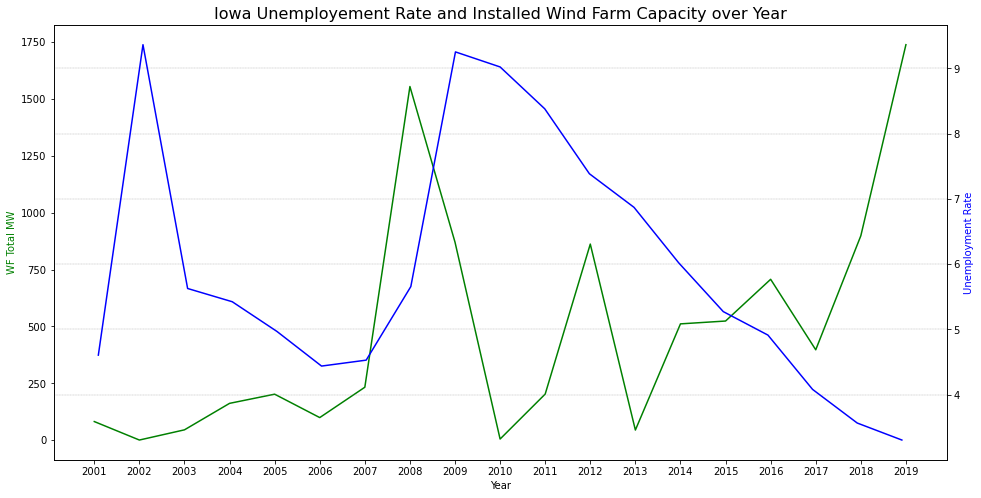

In [312]:
iowa_year = iowa_df.groupby(['Year'])
iowa_year_MW = iowa_year['WF Total MW'].sum()

ia_unem_year = iowa_census.groupby(['Year'])
ia_unem_year = ia_unem_year['Unemployment Rate'].mean()


df_ia_year = pd.merge(iowa_year_MW,ia_unem_year,on='Year', how ='outer')
df_final = df_ia_year.dropna()
y1 = df_final['WF Total MW']
y2 = df_final['Unemployment Rate']

x = df_final.index
fig, ax1 = plt.subplots(figsize=(16, 8))

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('Year')
ax1.set_ylabel('WF Total MW', color='g')
ax2.set_ylabel('Unemployment Rate', color='b')
plt.grid(color='grey', linestyle='--', linewidth=0.3)
plt.xticks(range(2000,2021))
plt.title('Iowa Unemployement Rate and Installed Wind Farm Capacity over Year', fontsize=16)
plt.show()

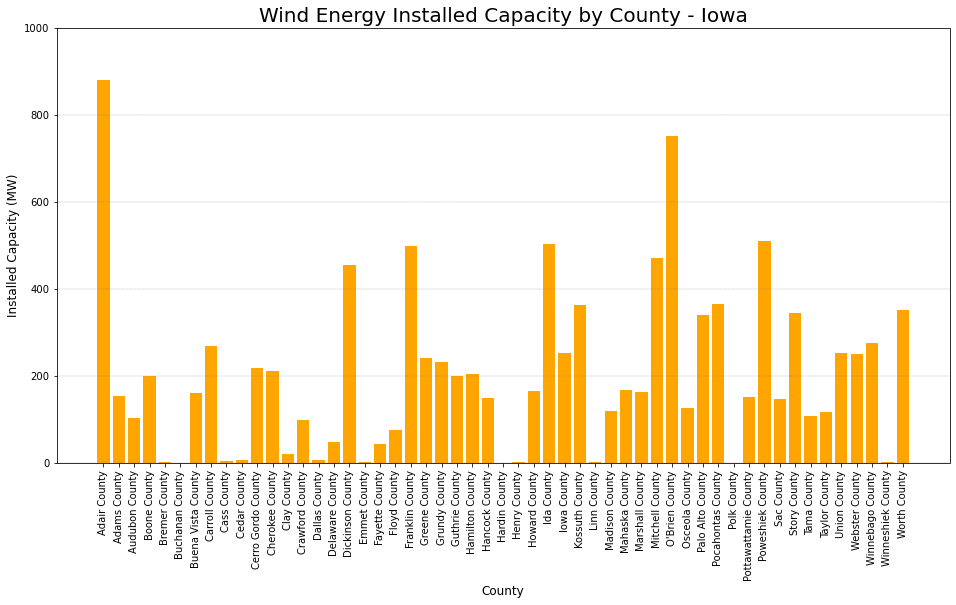

In [313]:
WF_IA = iowa_df.groupby('County')
WF_county_IA = WF_IA['WF Total MW'].sum()
x = WF_county_IA.index
y = WF_county_IA.values
plt.subplots(figsize=(16, 8))
plt.bar(x,y,color='orange')
plt.xlabel('County',fontsize=12)
plt.ylabel('Installed Capacity (MW)',fontsize=12)
plt.title('Wind Energy Installed Capacity by County - Iowa',fontsize=20)
plt.ylim(0,1000)
plt.xticks(rotation = 90)
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.3)
plt.show()

In [314]:
# add columns with max and min years for every county
IA_max_min_year = pd.merge(iowa_census,IA_county_max_year, on= 'County', how = 'outer')
IA_max_min_year = IA_max_min_year.rename(columns={'Year_x': 'Year','Year_y':'Max year'})
IA_max_min_year = pd.merge(IA_max_min_year,IA_county_min_year, on= 'County', how = 'outer')
IA_max_min_year = IA_max_min_year.rename(columns={'Year_x': 'Year','Year_y':'Min year'})

#creates a dataframe with with unemployment rate at the last year that the county had wind farm installed
IA_df_max = IA_max_min_year.loc[IA_max_min_year['Year']==IA_max_min_year['Max year']]
IA_df_max = IA_df_max.drop(columns={'State','Year','Max year','Min year'})
IA_df_max = IA_df_max.rename(columns={'Unemployment Rate': 'Unemployment Rate Last Year','Population':'Population Last Year'})

#creates a dataframe with with unemployment rate at the year before the county had its first wind farm installed
IA_df_min = IA_max_min_year.loc[IA_max_min_year['Year']==IA_max_min_year['Min year']]
IA_df_min = IA_df_min.drop(columns={'State','Year','Max year','Min year'})
IA_df_min = IA_df_min.rename(columns={'Unemployment Rate': 'Unemployment Rate Year Before WF','Population':'Population First Year'})

# 
IA_df = pd.merge(IA_df_min,IA_df_max,on= 'County', how = 'outer')

IA_df['Rate Changing'] = (((IA_df['Unemployment Rate Last Year']).astype(float) / (IA_df['Unemployment Rate Year Before WF']).astype(float))-1) * 100
IA_df = pd.merge(IA_df,WF_county_IA,on= 'County', how = 'outer')
IA_df = IA_df.dropna(subset=['Rate Changing'])

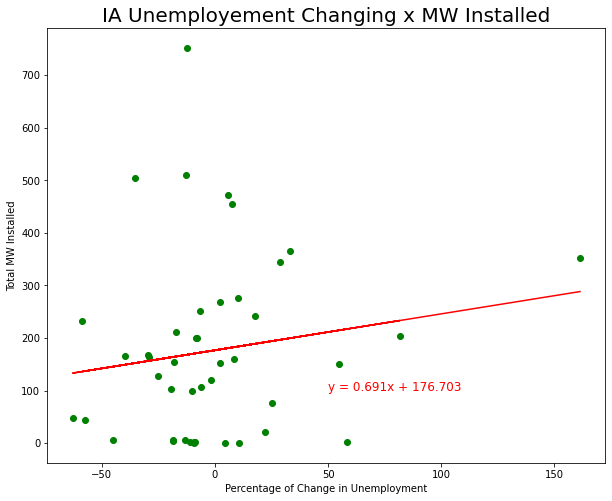

The r-squared is: 0.024


In [315]:
# scatter plot of unemployment rate changing and total MW installed in the couties

regress_values=[]
x = IA_df['Rate Changing'].astype(float)
y = IA_df['WF Total MW'].astype(float)


plt.subplots(figsize=(10, 8))
(slope, intercept, rvalue, pvalue, stderr) = linregress(x,y)
regress_values = np.asarray(x) * slope + intercept
line_eq = "y = " + str(round(slope,3)) + "x + " + str(round(intercept,3))
plt.scatter(x,y,  color = 'green')
plt.plot(x,regress_values,"r-")

plt.annotate(line_eq,(50, 100),fontsize=12,color="red")
plt.xlabel('Percentage of Change in Unemployment')
plt.ylabel('Total MW Installed')
plt.title('IA Unemployement Changing x MW Installed',fontsize=20)
plt.show()
print(f"The r-squared is: {round(rvalue**2,4)}")


# Oklahoma Plots

In [316]:
# create df for oklahoma
oklahoma_df = modern_WF_MW.loc[(modern_WF_MW['State']=='OK')]
oklahoma_df

,State,County,Wind Farm Name,Year,Turbine Count,WF Total MW,Turbine Manufacturer,Turbine Model,Turbine Hub Height,Rotor Diameter,lng,lat,Duplicated
1544,OK,Murray County,Arbuckle Mountain,2015.0,50,100.00,Vestas,V110-2.0,80.0,110.0,-97.19896,34.39424,False
1632,OK,Garfield County,Armadillo Flats,2018.0,126,247.28,GE Wind,GE1.79-100,80.0,100.0,-97.53968,36.27013,False
2440,OK,Beaver County,Balko Wind,2015.0,162,299.70,GE Wind,GE1.85-87,80.0,87.0,-100.80332,36.54136,False
3799,OK,Roger Mills County,Big Smile Wind Farm at Dempsey Ridge,2012.0,66,132.00,Gamesa,G90-2.0,78.0,90.0,-99.84719,35.53270,False
4891,OK,Kay County,Blackwell,2012.0,26,59.80,Siemens,SWT-2.3-108,80.0,108.0,-97.42510,36.86459,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55007,OK,Dewey County,Taloga,2011.0,54,129.60,Mitsubishi,MWT95/2.4,80.0,95.0,-98.93169,35.84679,False
55324,OK,Noble County,Thunder Ranch,2017.0,120,297.80,GE Wind,GE2.3-116,80.0,116.0,-97.30306,36.57061,False
58516,OK,Custer County,Weatherford Wind Energy Center,2005.0,71,106.50,GE Wind,GE1.5-77,80.0,77.0,-98.74320,35.49469,False
58588,OK,Washita County,Weatherford Wind Energy Center Expansion,2005.0,27,40.50,GE Wind,GE1.5-77,80.0,77.0,-98.65730,35.46230,False


In [317]:
# group oklahoma_df by county and get the year before the first year of wind farm installation and the last year of wind farm installation
OK_county = oklahoma_df.groupby('County')
OK_county_max_year = OK_county['Year'].max()
OK_county_min_year = (OK_county['Year'].min())-1

In [318]:
# pull oklahoma census
oklahoma_census = census_df[census_df["State"] == "OK"]
oklahoma_census

,State,County,Year,Population,Unemployment Rate
0,OK,Oklahoma,2000,"3,454,365",3.0
1,OK,Adair County,2000,"21,031",2.6
2,OK,Alfalfa County,2000,"6,080",2.9
3,OK,Atoka County,2000,"13,820",3.6
4,OK,Beaver County,2000,"5,782",2.4
...,...,...,...,...,...
9001,OK,Wagoner County,2019,81289,3.1
9002,OK,Washington County,2019,51527,4.6
9003,OK,Washita County,2019,10916,3.4
9004,OK,Woods County,2019,8793,2.1


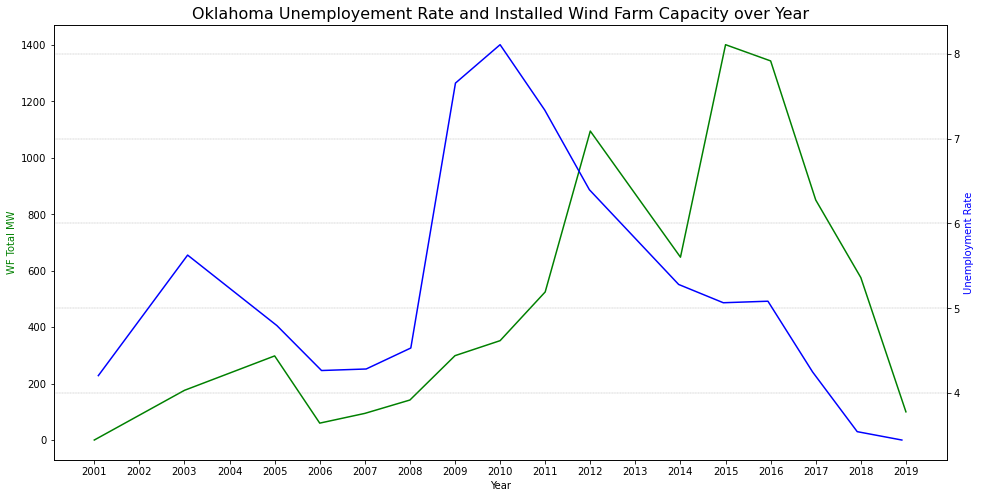

In [319]:
oklahoma_year = oklahoma_df.groupby(['Year'])
oklahoma_year_MW = oklahoma_year['WF Total MW'].sum()

ok_unem_year = oklahoma_census.groupby(['Year'])
ok_unem_year = ok_unem_year['Unemployment Rate'].mean()


df_ok_year = pd.merge(oklahoma_year_MW,ok_unem_year,on='Year', how ='outer')
df_final = df_ok_year.dropna()
y1 = df_final['WF Total MW']
y2 = df_final['Unemployment Rate']

x = df_final.index
fig, ax1 = plt.subplots(figsize=(16, 8))

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('Year')
ax1.set_ylabel('WF Total MW', color='g')
ax2.set_ylabel('Unemployment Rate', color='b')
plt.grid(color='grey', linestyle='--', linewidth=0.3)
plt.xticks(range(2000,2021))
plt.title('Oklahoma Unemployement Rate and Installed Wind Farm Capacity over Year', fontsize=16)

plt.show()

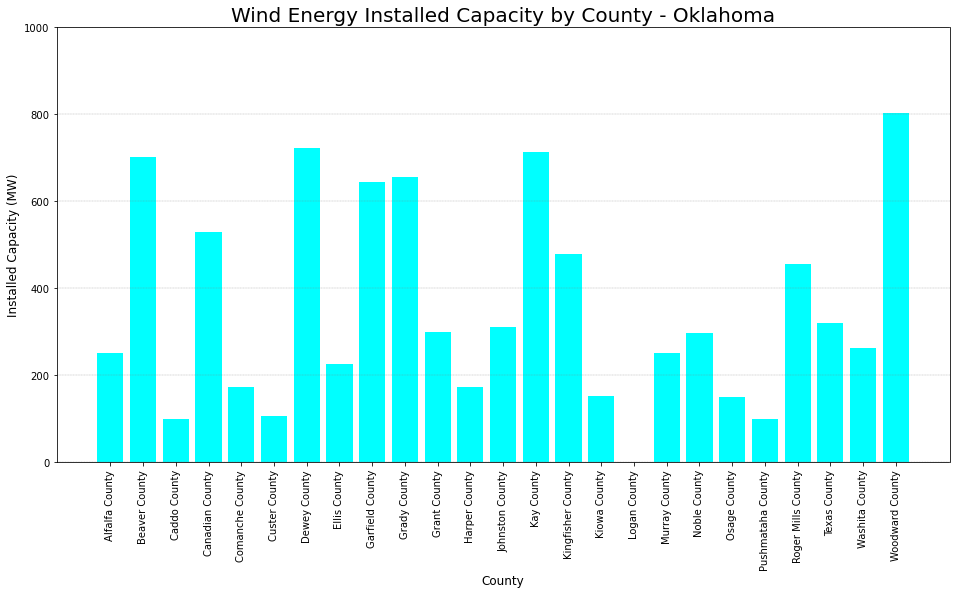

In [320]:
WF_OK = oklahoma_df.groupby('County')
WF_county_OK = WF_OK['WF Total MW'].sum()
x = WF_county_OK.index
y = WF_county_OK.values
plt.subplots(figsize=(16, 8))
plt.bar(x,y,color='cyan')
plt.xlabel('County',fontsize=12)
plt.ylabel('Installed Capacity (MW)',fontsize=12)
plt.title('Wind Energy Installed Capacity by County - Oklahoma',fontsize=20)
plt.ylim(0,1000)
plt.xticks(rotation = 90)
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.3)
plt.show()

In [321]:
OK_max_min_year = pd.merge(oklahoma_census,OK_county_max_year, on= 'County', how = 'outer')
OK_max_min_year = OK_max_min_year.rename(columns={'Year_x': 'Year','Year_y':'Max year'})
OK_max_min_year = pd.merge(OK_max_min_year,OK_county_min_year, on= 'County', how = 'outer')
OK_max_min_year = OK_max_min_year.rename(columns={'Year_x': 'Year','Year_y':'Min year'})

#creates a dataframe with with unemployment rate at the last year that the county had wind farm installed
OK_df_max = OK_max_min_year.loc[OK_max_min_year['Year']==OK_max_min_year['Max year']]
OK_df_max = OK_df_max.drop(columns={'State','Year','Max year','Min year'})
OK_df_max = OK_df_max.rename(columns={'Unemployment Rate': 'Unemployment Rate Last Year','Population':'Population Last Year'})

#creates a dataframe with with unemployment rate at the year before the county had its first wind farm installed
OK_df_min = OK_max_min_year.loc[OK_max_min_year['Year']==OK_max_min_year['Min year']]
OK_df_min = OK_df_min.drop(columns={'State','Year','Max year','Min year'})
OK_df_min = OK_df_min.rename(columns={'Unemployment Rate': 'Unemployment Rate Year Before WF','Population':'Population First Year'})

# 
OK_df = pd.merge(OK_df_min,OK_df_max,on= 'County', how = 'outer')

OK_df['Rate Changing'] = (((OK_df['Unemployment Rate Last Year']).astype(float) / (OK_df['Unemployment Rate Year Before WF']).astype(float))-1) * 100
OK_df = pd.merge(OK_df,WF_county_OK,on= 'County', how = 'outer')
OK_df = OK_df.dropna(subset=['Rate Changing'])
OK_df

,County,Population First Year,Unemployment Rate Year Before WF,Population Last Year,Unemployment Rate Last Year,Rate Changing,WF Total MW
2,Caddo County,29600,6.9,29602,7.1,2.898551,99.00
3,Canadian County,119397,4.4,144426,2.8,-36.363636,529.13
4,Comanche County,"113,551",3.9,"119,952",3.5,-10.256410,173.25
5,Custer County,"25,631",5.1,"25,876",4.7,-7.843137,106.50
6,Dewey County,4810,5.2,4966,3.1,-40.384615,722.90
7,Ellis County,4223,3.0,4085,3.1,3.333333,225.00
8,Garfield County,60763,9.5,61095,3.1,-67.368421,645.38
9,Grady County,"52,231",9.7,54829,4.8,-50.515464,656.10
10,Grant County,4500,4.5,4454,3.6,-20.000000,299.00
11,Harper County,"3,458",3.7,"3,645",3.2,-13.513514,173.40


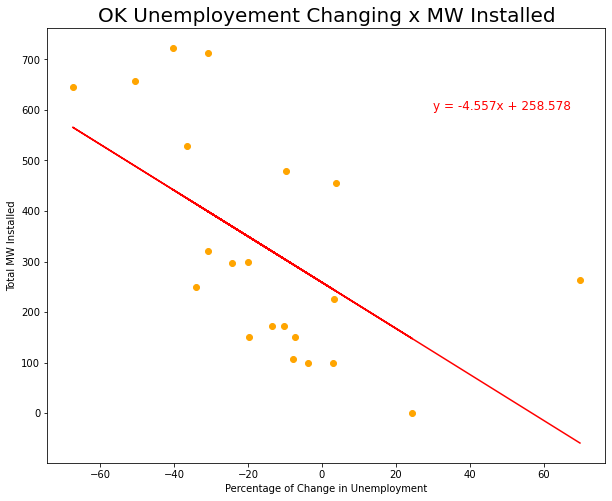

The r-squared is: 0.3393


In [322]:
# scatter plot of unemployment rate changing and total MW installed in the couties

regress_values=[]
x = OK_df['Rate Changing'].astype(float)
y = OK_df['WF Total MW'].astype(float)


plt.subplots(figsize=(10, 8))
(slope, intercept, rvalue, pvalue, stderr) = linregress(x,y)
regress_values = np.asarray(x) * slope + intercept
line_eq = "y = " + str(round(slope,3)) + "x + " + str(round(intercept,3))
plt.scatter(x,y,  color = 'orange')
plt.plot(x,regress_values,"r-")

plt.annotate(line_eq,(30, 600),fontsize=12,color="red")
plt.xlabel('Percentage of Change in Unemployment')
plt.ylabel('Total MW Installed')
plt.title('OK Unemployement Changing x MW Installed',fontsize=20)
plt.show()
print(f"The r-squared is: {round(rvalue**2,4)}")


# Oregon plots

In [323]:
# create df for oregon
oregon_df = modern_WF_MW.loc[modern_WF_MW['State']=='OR']
oregon_df.head()

,State,County,Wind Farm Name,Year,Turbine Count,WF Total MW,Turbine Manufacturer,Turbine Model,Turbine Hub Height,Rotor Diameter,lng,lat,Duplicated
3224,OR,Baker County,Benson Creek,2017.0,5,10.0,GE Wind,GE2.0-116,80.0,116.0,-117.27673,44.42429,False
3904,OR,Sherman County,Biglow Canyon I,2007.0,76,125.4,Vestas,V82-1.65,80.0,82.0,-120.58518,45.66919,False
3980,OR,Sherman County,Biglow Canyon II,2009.0,65,149.5,Siemens,SWT-2.3-93,80.0,93.0,-120.59669,45.63350,False
4046,OR,Sherman County,Biglow Canyon III,2010.0,76,174.8,Siemens,SWT-2.3-93,80.0,93.0,-120.54809,45.64840,False
12516,OR,Umatilla County,Chopin,2016.0,6,9.9,GE Wind,GE1.7-103,80.0,103.0,-118.47427,45.89413,False


In [324]:
# group oregon_df by county and get the year before the first year of wind farm installation and the last year of wind farm installation
OR_county = oregon_df.groupby('County')
OR_county_max_year = OR_county['Year'].max()
OR_county_min_year = (OR_county['Year'].min())-1

In [325]:
# pull oregon census
oregon_census = census_df[census_df["State"] == "OR"]
oregon_census

,State,County,Year,Population,Unemployment Rate
431,OR,Baker County,2000,"16,714",3.0
432,OR,Benton County,2000,"78,236",2.8
433,OR,Clackamas County,2000,"339,223",4.0
434,OR,Clatsop County,2000,"35,560",5.0
435,OR,Columbia County,2000,"43,634",5.2
...,...,...,...,...,...
8923,OR,Wallowa County,2019,7208,5.8
8924,OR,Wasco County,2019,26682,4.1
8925,OR,Washington County,2019,601592,4.6
8926,OR,Wheeler County,2019,1332,7.5


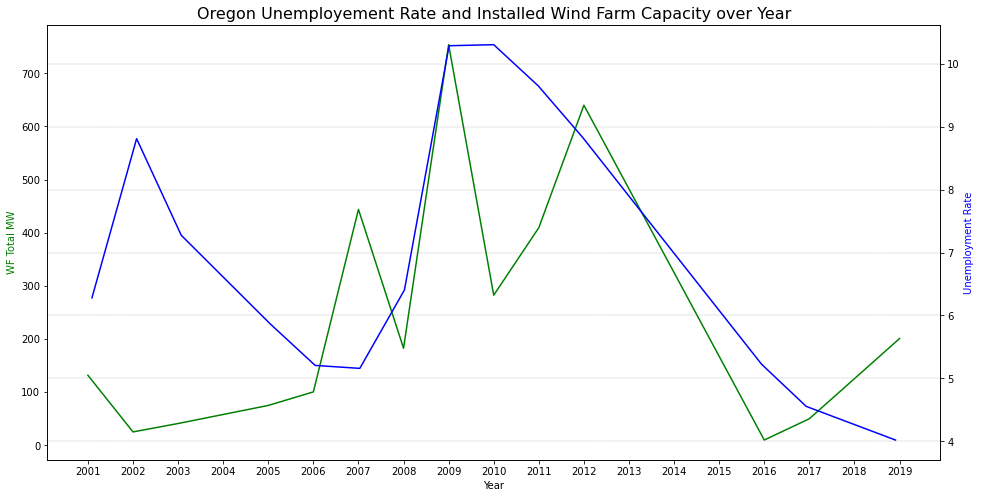

In [326]:
oregon_year = oregon_df.groupby(['Year'])
oregon_year_MW = oregon_year['WF Total MW'].sum()

or_unem_year = oregon_census.groupby(['Year'])
or_unem_year = or_unem_year['Unemployment Rate'].mean()


df_or_year = pd.merge(oregon_year_MW,or_unem_year,on='Year', how ='outer')
df_final = df_or_year.dropna()
y1 = df_final['WF Total MW']
y2 = df_final['Unemployment Rate']

x = df_final.index
fig, ax1 = plt.subplots(figsize=(16, 8))

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('Year')
ax1.set_ylabel('WF Total MW', color='g')
ax2.set_ylabel('Unemployment Rate', color='b')
plt.grid(color='grey', linestyle='--', linewidth=0.3)
plt.xticks(range(2000,2021))
plt.title('Oregon Unemployement Rate and Installed Wind Farm Capacity over Year', fontsize=16)
plt.show()


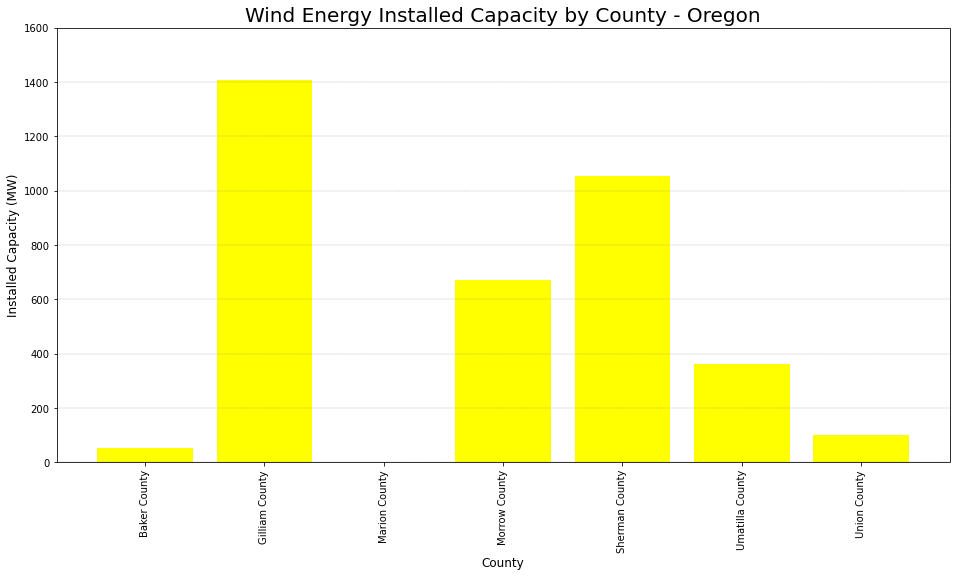

In [327]:
WF_OR = oregon_df.groupby('County')
WF_county_OR = WF_OR["WF Total MW"].sum()
x = WF_county_OR.index
y = WF_county_OR.values
plt.subplots(figsize=(16, 8))
plt.bar(x,y,color = 'yellow')
plt.xlabel('County',fontsize=12)
plt.ylabel('Installed Capacity (MW)',fontsize=12)
plt.title('Wind Energy Installed Capacity by County - Oregon',fontsize=20)
plt.ylim(0,1600)
plt.xticks(rotation = 90)
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.3)
plt.show()

In [328]:
OR_max_min_year = pd.merge(oregon_census,OR_county_max_year, on= 'County', how = 'outer')
OR_max_min_year = OR_max_min_year.rename(columns={'Year_x': 'Year','Year_y':'Max year'})
OR_max_min_year = pd.merge(OR_max_min_year,OR_county_min_year, on= 'County', how = 'outer')
OR_max_min_year = OR_max_min_year.rename(columns={'Year_x': 'Year','Year_y':'Min year'})

#creates a dataframe with with unemployment rate at the last year that the county had wind farm installed
OR_df_max = OR_max_min_year.loc[OR_max_min_year['Year']==OR_max_min_year['Max year']]
OR_df_max = OR_df_max.drop(columns={'State','Year','Max year','Min year'})
OR_df_max = OR_df_max.rename(columns={'Unemployment Rate': 'Unemployment Rate Last Year','Population':'Population Last Year'})

#creates a dataframe with with unemployment rate at the year before the county had its first wind farm installed
OR_df_min = OR_max_min_year.loc[OR_max_min_year['Year']==OR_max_min_year['Min year']]
OR_df_min = OR_df_min.drop(columns={'State','Year','Max year','Min year'})
OR_df_min = OR_df_min.rename(columns={'Unemployment Rate': 'Unemployment Rate Year Before WF','Population':'Population First Year'})

# 
OR_df = pd.merge(OR_df_min,OR_df_max,on= 'County', how = 'outer')

OR_df['Rate Changing'] = (((OR_df['Unemployment Rate Last Year']).astype(float) / (OR_df['Unemployment Rate Year Before WF']).astype(float))-1) * 100
OR_df = pd.merge(OR_df,WF_county_OR,on= 'County', how = 'outer')
OR_df = OR_df.dropna(subset=['Rate Changing'])
OR_df

,County,Population First Year,Unemployment Rate Year Before WF,Population Last Year,Unemployment Rate Last Year,Rate Changing,WF Total MW
0,Baker County,16134,11.3,16083,4.2,-62.831858,53.00
1,Gilliam County,"1,908",4.8,1912,3.7,-22.916667,1405.65
2,Marion County,315335,13.6,318047,11.2,-17.647059,0.25
4,Sherman County,"1,921",2.7,1765,4.8,77.777778,1054.90
5,Umatilla County,"70,728",6.1,76686,5.3,-13.114754,360.51
6,Union County,"24,754",6.6,"25,473",6.4,-3.030303,100.65


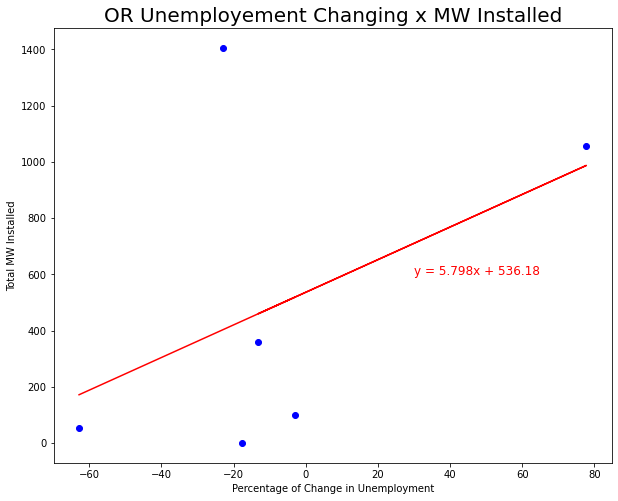

The r-squared is: 0.2052


In [329]:
# scatter plot of unemployment rate changing and total MW installed in the couties

regress_values=[]
x = OR_df['Rate Changing'].astype(float)
y = OR_df['WF Total MW'].astype(float)


plt.subplots(figsize=(10, 8))
(slope, intercept, rvalue, pvalue, stderr) = linregress(x,y)
regress_values = np.asarray(x) * slope + intercept
line_eq = "y = " + str(round(slope,3)) + "x + " + str(round(intercept,3))
plt.scatter(x,y,  color = 'blue')
plt.plot(x,regress_values,"r-")

plt.annotate(line_eq,(30, 600),fontsize=12,color="red")
plt.xlabel('Percentage of Change in Unemployment')
plt.ylabel('Total MW Installed')
plt.title('OR Unemployement Changing x MW Installed',fontsize=20)
plt.show()
print(f"The r-squared is: {round(rvalue**2,4)}")


# Texas plot

In [330]:
texas_df = modern_WF_MW.loc[modern_WF_MW['State']=='TX']
texas_df

,State,County,Wind Farm Name,Year,Turbine Count,WF Total MW,Turbine Manufacturer,Turbine Model,Turbine Hub Height,Rotor Diameter,lng,lat,Duplicated
781,TX,Fisher County,Amadeus,2020.0,96,250.12,GE Wind,GE2.82-127,89.0,127.0,-100.56799,32.91327,False
942,TX,Scurry County,Amazon Wind Farm Texas,2017.0,110,253.00,GE Wind,GE2.3-116,80.0,116.0,-101.00261,32.87671,False
1205,TX,Lubbock County,American Windmill Museum,2005.0,1,0.66,Vestas,V47-0.66,50.0,47.0,-101.82389,33.58089,False
1206,TX,Kinney County,Anacacho,2012.0,55,99.00,Vestas,V100-1.8,80.0,100.0,-100.20351,29.18324,False
1280,TX,Denton County,Apogee Stadium Wind,2012.0,3,0.30,Northern Power Systems,NW100,37.0,21.0,-97.16100,33.20120,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60596,TX,Archer County,Windthorst-2,2014.0,28,64.40,Siemens,SWT-2.3-108,80.0,108.0,-98.50011,33.49516,False
60820,TX,Cooke County,Wolf Ridge,2008.0,75,112.50,GE Wind,GE1.5-82.5,80.0,82.5,-97.44919,33.73179,False
60947,TX,Pecos County,Woodward Mountain I,2001.0,125,82.50,Gamesa,G47-0.66,50.0,47.0,-102.47739,30.94780,False
61074,TX,Pecos County,Woodward Mountain II,2001.0,115,75.90,Gamesa,G47-0.66,50.0,47.0,-102.42529,30.94320,False


In [331]:
# group texas_df by county and get the year before the first year of wind farm installation and the last year of wind farm installation
TX_county = texas_df.groupby('County')
TX_county_max_year = TX_county['Year'].max()
TX_county_min_year = (TX_county['Year'].min())-1

In [332]:
# pull texas census
texas_census = census_df[census_df["State"] == "TX"]
texas_census

,State,County,Year,Population,Unemployment Rate
177,TX,Anderson County,2000,"55,062",4.1
178,TX,Andrews County,2000,"12,949",4.9
179,TX,Angelina County,2000,"80,270",4.8
180,TX,Aransas County,2000,"22,452",5.9
181,TX,Archer County,2000,"8,966",3.2
...,...,...,...,...,...
9256,TX,Wood County,2019,45539,3.7
9257,TX,Yoakum County,2019,8713,2.9
9258,TX,Young County,2019,18010,3.0
9259,TX,Zapata County,2019,14179,5.1


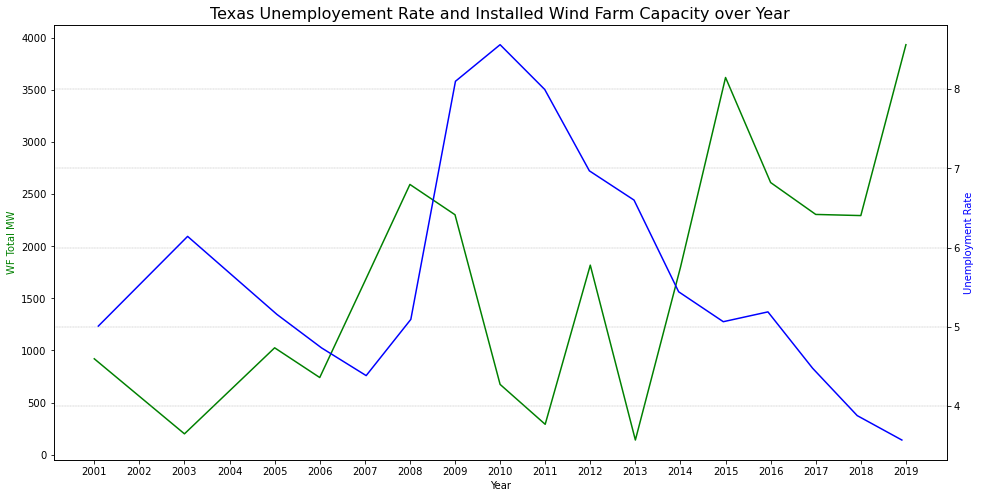

In [333]:
texas_year =texas_df.groupby(['Year'])
texas_year_MW = texas_year['WF Total MW'].sum()

tx_unem_year = texas_census.groupby(['Year'])
tx_unem_year = tx_unem_year['Unemployment Rate'].mean()


df_tx_year = pd.merge(texas_year_MW,tx_unem_year,on='Year', how ='outer')
df_final = df_tx_year.dropna()
y1 = df_final['WF Total MW']
y2 = df_final['Unemployment Rate']

x = df_final.index
fig, ax1 = plt.subplots(figsize=(16, 8))

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('Year')
ax1.set_ylabel('WF Total MW', color='g')
ax2.set_ylabel('Unemployment Rate', color='b')
plt.grid(color='grey', linestyle='--', linewidth=0.3)
plt.xticks(range(2000,2021))
plt.title('Texas Unemployement Rate and Installed Wind Farm Capacity over Year', fontsize=16)
plt.show()

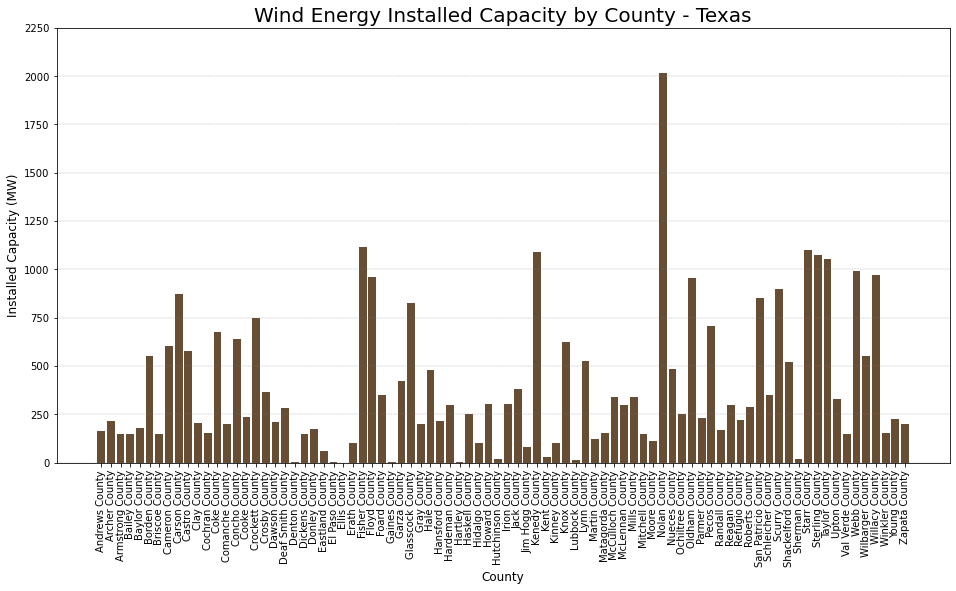

In [334]:
WF_TX = texas_df.groupby('County')
WF_county_TX = WF_TX["WF Total MW"].sum()
x = WF_county_TX.index
y = WF_county_TX.values
plt.subplots(figsize=(16, 8))
plt.bar(x,y,color = (0.4, 0.3, 0.2))
plt.xlabel('County',fontsize=12)
plt.ylabel('Installed Capacity (MW)',fontsize=12)
plt.title('Wind Energy Installed Capacity by County - Texas',fontsize=20)
plt.ylim(0,2250)
plt.xticks(rotation = 90)
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.3)
plt.show()

In [335]:
TX_max_min_year = pd.merge(texas_census,TX_county_max_year, on= 'County', how = 'outer')
TX_max_min_year = TX_max_min_year.rename(columns={'Year_x': 'Year','Year_y':'Max year'})
TX_max_min_year = pd.merge(TX_max_min_year,TX_county_min_year, on= 'County', how = 'outer')
TX_max_min_year = TX_max_min_year.rename(columns={'Year_x': 'Year','Year_y':'Min year'})

#creates a dataframe with with unemployment rate at the last year that the county had wind farm installed
TX_df_max = TX_max_min_year.loc[TX_max_min_year['Year']==TX_max_min_year['Max year']]
TX_df_max = TX_df_max.drop(columns={'State','Year','Max year','Min year'})
TX_df_max = TX_df_max.rename(columns={'Unemployment Rate': 'Unemployment Rate Last Year','Population':'Population Last Year'})

#creates a dataframe with with unemployment rate at the year before the county had its first wind farm installed
TX_df_min = TX_max_min_year.loc[TX_max_min_year['Year']==TX_max_min_year['Min year']]
TX_df_min = TX_df_min.drop(columns={'State','Year','Max year','Min year'})
TX_df_min = TX_df_min.rename(columns={'Unemployment Rate': 'Unemployment Rate Year Before WF','Population':'Population First Year'})

# 
TX_df = pd.merge(TX_df_min,TX_df_max,on= 'County', how = 'outer')

TX_df['Rate Changing'] = (((TX_df['Unemployment Rate Last Year']).astype(float) / (TX_df['Unemployment Rate Year Before WF']).astype(float))-1) * 100
TX_df = pd.merge(TX_df,WF_county_TX,on= 'County', how = 'outer')
TX_df = TX_df.dropna(subset=['Rate Changing'])
TX_df

,County,Population First Year,Unemployment Rate Year Before WF,Population Last Year,Unemployment Rate Last Year,Rate Changing,WF Total MW
1,Archer County,8840,6.1,8844,4.5,-26.229508,214.40
2,Armstrong County,1913,6.4,1901,6.6,3.125000,150.00
3,Bailey County,7066,4.3,7015,4.4,2.325581,148.35
4,Baylor County,3566,4.2,3509,2.3,-45.238095,180.24
5,Borden County,597,4.0,654,2.5,-37.500000,549.22
...,...,...,...,...,...,...,...
77,Val Verde County,48911,6.2,49028,5.1,-17.741935,149.34
78,Webb County,"245,908",8.5,275120,3.7,-56.470588,990.89
79,Wilbarger County,13452,7.3,12769,3.6,-50.684932,549.15
81,Winkler County,"7,024",3.7,"7,128",9.3,151.351351,152.61


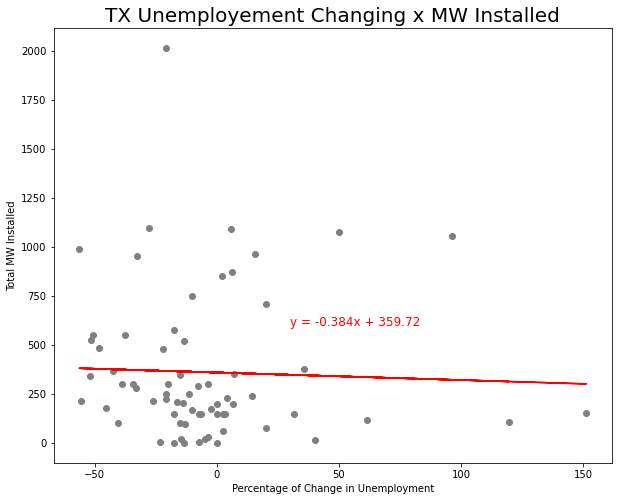

The r-squared is: 0.0015


In [336]:
# scatter plot of unemployment rate changing and total MW installed in the couties

regress_values=[]
x = TX_df['Rate Changing'].astype(float)
y = TX_df['WF Total MW'].astype(float)


plt.subplots(figsize=(10, 8))
(slope, intercept, rvalue, pvalue, stderr) = linregress(x,y)
regress_values = np.asarray(x) * slope + intercept
line_eq = "y = " + str(round(slope,3)) + "x + " + str(round(intercept,3))
plt.scatter(x,y,  color = 'grey')
plt.plot(x,regress_values,"r-")

plt.annotate(line_eq,(30, 600),fontsize=12,color="red")
plt.xlabel('Percentage of Change in Unemployment')
plt.ylabel('Total MW Installed')
plt.title('TX Unemployement Changing x MW Installed',fontsize=20)
plt.show()
print(f"The r-squared is: {round(rvalue**2,4)}")


In [337]:
base_url = 'http://api.eia.gov/series/?'

In [338]:
# creates empty series
coal_prod = []
oil_prod = []
geothermal_prod = []
hydropower_prod = []
naturalgasdry_prod = []
naturalgasliquid_prod = []
nuclear_prod = []
solar_prod = []
biomass_prod = []
wind_prod = []
fossilfuel_prod = []
renewable_prod = []
coal_x = []
coal_y = []
oil_x = []
oil_y = []
geothermal_x =[]
geothermal_y =[]
hydropower_x =[]
hydropower_y =[]
naturalgasdry_x =[]
naturalgasdry_y =[]
naturalgasliquid_x =[]
naturalgasliquid_y =[]
nuclear_x =[]
nuclear_y =[]
solar_x =[]
solar_y =[]
biomass_x =[]
biomass_y =[]
wind_x =[]
wind_y =[]
fossilfuel_x =[]
fossilfuel_y =[]
renewable_x = []
renewable_y = []
CO2total_x = []
CO2total_y = []
CO2total = []

# US Enenery Information Administration (EIA) API

# Get energy production generated by coal in the USA
series_name = 'TOTAL.CLPRBUS.A;'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
coal_response = requests.get(query_url).json()
coal_prod.append(coal_response['series'][0]['data'])
coal_prod = coal_prod[0]
for i in reversed (coal_prod):
    coal_x.append(i[0])
    coal_y.append(i[1])

# Get energy production generated by oil in the USA
series_name = 'TOTAL.PAPRBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
oil_response = requests.get(query_url).json()
oil_prod.append(oil_response['series'][0]['data'])
oil_prod = oil_prod[0]
for i in reversed (oil_prod):
    oil_x.append(i[0]) 
    oil_y.append(i[1])

# Get energy production generated by geothermal in the USA
series_name = 'TOTAL.GETCBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
geothermal_response = requests.get(query_url).json()
geothermal_prod.append(geothermal_response['series'][0]['data'])
geothermal_prod = geothermal_prod[0]
for i in reversed (geothermal_prod):
    geothermal_x.append(i[0]) 
    geothermal_y.append(i[1])

# Get energy production generated by hydro in the USA
series_name = 'TOTAL.HVTCBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
hydropower_response = requests.get(query_url).json()
hydropower_prod.append(hydropower_response['series'][0]['data'])
hydropower_prod = hydropower_prod[0]
for i in reversed (hydropower_prod):
    hydropower_x.append(i[0]) 
    hydropower_y.append(i[1])

# Get energy production generated by dry natural gas in the USA
series_name = 'TOTAL.NGPRBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
naturalgasdry_response = requests.get(query_url).json()
naturalgasdry_prod.append(naturalgasdry_response['series'][0]['data'])
naturalgasdry_prod = naturalgasdry_prod[0]
for i in reversed (naturalgasdry_prod):
    naturalgasdry_x.append(i[0]) 
    naturalgasdry_y.append(i[1])

# Get energy production generated by liquid natural gas in the USA
series_name = 'TOTAL.NLPRBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
naturalgasliquid_response = requests.get(query_url).json()
naturalgasliquid_prod.append(naturalgasliquid_response['series'][0]['data'])
naturalgasliquid_prod = naturalgasliquid_prod[0]
for i in reversed (naturalgasliquid_prod):
    naturalgasliquid_x.append(i[0]) 
    naturalgasliquid_y.append(i[1])

# Get energy production generated by nuclear in the USA
series_name = 'TOTAL.NUETBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
nuclear_response = requests.get(query_url).json()
nuclear_prod.append(nuclear_response['series'][0]['data'])
nuclear_prod = nuclear_prod[0]
for i in reversed (nuclear_prod):
    nuclear_x.append(i[0]) 
    nuclear_y.append(i[1])

# Get energy production generated by solar in the USA
series_name = 'TOTAL.SOTCBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
solar_response = requests.get(query_url).json()
solar_prod.append(solar_response['series'][0]['data'])
solar_prod = solar_prod[0]
for i in reversed (solar_prod):
    solar_x.append(i[0]) 
    solar_y.append(i[1])
    
# Get energy production generated by biomass in the USA
series_name = 'TOTAL.BMPRBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
biomass_response = requests.get(query_url).json()
biomass_prod.append(biomass_response['series'][0]['data'])
biomass_prod = biomass_prod[0]
for i in reversed (biomass_prod):
    biomass_x.append(i[0]) 
    biomass_y.append(i[1])

# Get energy production generated by wind in the USA
series_name = 'TOTAL.WYTCBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
wind_response = requests.get(query_url).json()
wind_prod.append(wind_response['series'][0]['data'])
wind_prod = wind_prod[0]
for i in reversed (wind_prod):
    wind_x.append(i[0]) 
    wind_y.append(i[1])
    
# Get energy production generated by all fossil sources in the USA
series_name = 'TOTAL.FFPRBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
fossilfuel_response = requests.get(query_url).json()
fossilfuel_prod.append(fossilfuel_response['series'][0]['data'])
fossilfuel_prod = fossilfuel_prod[0]
for i in reversed (fossilfuel_prod):
    fossilfuel_x.append(i[0]) 
    fossilfuel_y.append(i[1])

# Get energy production generated by all renewable sources in the USA
series_name = 'TOTAL.REPRBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
renewable_response = requests.get(query_url).json()
renewable_prod.append(renewable_response['series'][0]['data'])
renewable_prod = renewable_prod[0]
for i in reversed (renewable_prod):
    renewable_x.append(i[0]) 
    renewable_y.append(i[1])

# Get CO2 emission in the USA

series_name = 'STEO.TETCCO2.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
CO2_response = requests.get(query_url).json()
CO2total.append(CO2_response['series'][0]['data'])
CO2total = CO2total[0]
for i in reversed (CO2total):
    CO2total_x.append(i[0]) 
    CO2total_y.append(i[1])


# Add sources to dataframe
coal_source = pd.DataFrame(coal_x)
coal_source.set_axis(['Year'], axis='columns', inplace=True)
coal_source['Coal'] = coal_y

oil_source = pd.DataFrame(oil_x)
oil_source.set_axis(['Year'], axis='columns', inplace=True)
oil_source['Oil'] = oil_y

source_df = pd.merge(coal_source,oil_source,on="Year", how="outer")

geothermal_source = pd.DataFrame(geothermal_x)
geothermal_source.set_axis(['Year'], axis='columns', inplace=True)
geothermal_source['Geothermal'] = geothermal_y
source_df = pd.merge(source_df,geothermal_source,on="Year", how="outer")

wind_source = pd.DataFrame(wind_x)
wind_source.set_axis(['Year'], axis='columns', inplace=True)
wind_source['Wind'] = wind_y
source_df = pd.merge(source_df,wind_source,on="Year", how="outer")

hydropower_source = pd.DataFrame(hydropower_x)
hydropower_source.set_axis(['Year'], axis='columns', inplace=True)
hydropower_source['Hydropower'] = hydropower_y
source_df = pd.merge(source_df,hydropower_source,on="Year", how="outer")

naturalgasdry_source = pd.DataFrame(naturalgasdry_x)
naturalgasdry_source.set_axis(['Year'], axis='columns', inplace=True)
naturalgasdry_source['Natural Gas Dry'] = naturalgasdry_y
source_df = pd.merge(source_df,naturalgasdry_source,on="Year", how="outer")

naturalgasliquid_source = pd.DataFrame(naturalgasliquid_x)
naturalgasliquid_source.set_axis(['Year'], axis='columns', inplace=True)
naturalgasliquid_source['Natural Gas Liquid'] = naturalgasliquid_y
source_df = pd.merge(source_df,naturalgasliquid_source,on="Year", how="outer")

nuclear_source = pd.DataFrame(nuclear_x)
nuclear_source.set_axis(['Year'], axis='columns', inplace=True)
nuclear_source['Nuclear'] = nuclear_y
source_df = pd.merge(source_df,nuclear_source,on="Year", how="outer")

solar_source = pd.DataFrame(solar_x)
solar_source.set_axis(['Year'], axis='columns', inplace=True)
solar_source['Solar'] = solar_y
source_df = pd.merge(source_df,solar_source,on="Year", how="outer")

biomass_source = pd.DataFrame(biomass_x)
biomass_source.set_axis(['Year'], axis='columns', inplace=True)
biomass_source['Biomass'] = biomass_y
source_df = pd.merge(source_df,biomass_source,on="Year", how="outer")

# Add source categories to dataframe
fossilfuel_source = pd.DataFrame(fossilfuel_x)
fossilfuel_source.set_axis(['Year'], axis='columns', inplace=True)
fossilfuel_source['Fossil Fuel'] = fossilfuel_y

main_sources = pd.DataFrame(renewable_x)
main_sources.set_axis(['Year'], axis='columns', inplace=True)
main_sources['Renewable'] = renewable_y

main_sources = pd.merge(main_sources,nuclear_source,on="Year", how="outer")
main_sources = pd.merge(main_sources,fossilfuel_source,on="Year", how="outer")


#CO2 data frame
CO2_df = pd.DataFrame(CO2total_x)
CO2_df.set_axis(['Year'], axis='columns', inplace=True)
CO2_df['CO2 Total'] = CO2total_y

source_df['Year'] = source_df['Year'].astype(int)
main_sources['Year'] = main_sources['Year'].astype(int)
CO2_df['Year'] = CO2_df['Year'].astype(int)
source = source_df.loc[source_df['Year'] >= 2000,:]
main_sources = main_sources.loc[main_sources['Year'] >= 2000,:]
CO2_df = CO2_df.loc[(CO2_df['Year'] >= 2000) & (CO2_df['Year'] < 2021),:]

# Plots

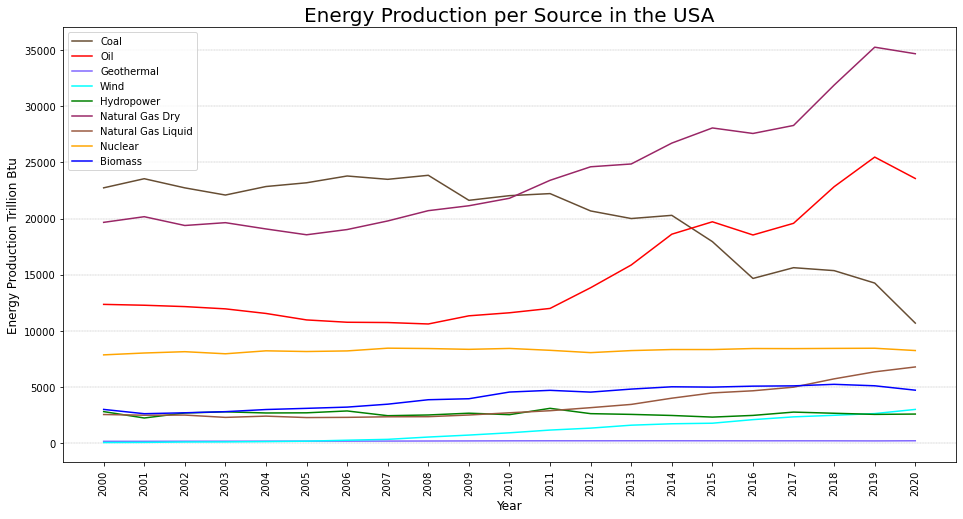

No handles with labels found to put in legend.


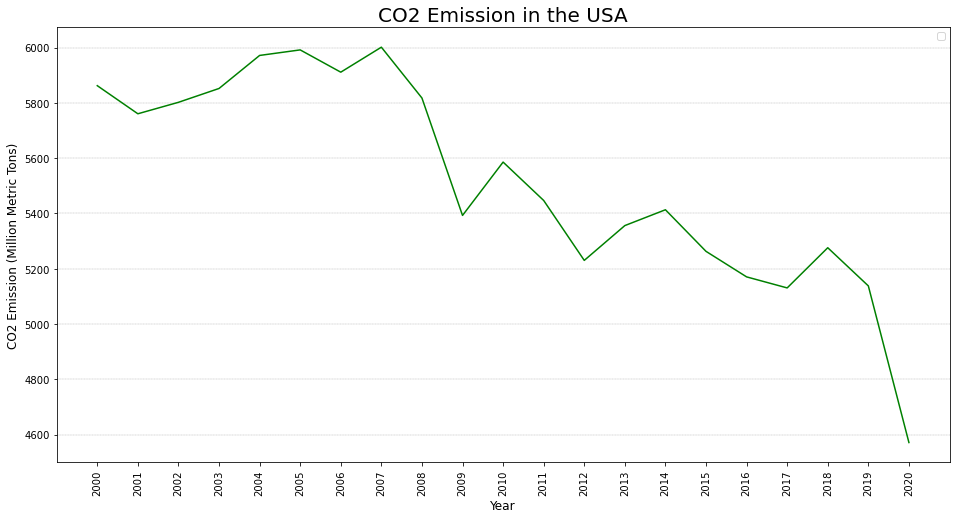

In [339]:
year = source['Year']
plt.subplots(figsize=(16, 8))
coal_handle, = plt.plot(year, source['Coal'], color=(0.4, 0.3, 0.2), label="Coal")
oil_handle, = plt.plot(year, source['Oil'], color='red', label="Oil")
geothermal_handle, = plt.plot(year, source['Geothermal'], color=(0.5, 0.4, 1.0), label="Geothermal")
wind_handle, = plt.plot(year, source['Wind'], color='cyan', label="Wind")
hydropower_handle, = plt.plot(year, source['Hydropower'], color='green', label="Hydropower")
naturalgasdry_handle, = plt.plot(year, source['Natural Gas Dry'], color=(0.6, 0.15, 0.4), label="Natural Gas Dry")
naturalgasliquid_handle, = plt.plot(year, source['Natural Gas Liquid'], color=(0.6, 0.35, 0.25), label="Natural Gas Liquid")
nuclear_handle, = plt.plot(year, source['Nuclear'], color='orange', label="Nuclear")
biomass_handle, = plt.plot(year, source['Biomass'], color='blue', label="Biomass")
plt.xticks(range(2000,2021))
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.3)
plt.xlabel('Year',fontsize=12)
plt.ylabel('Energy Production Trillion Btu',fontsize=12)
plt.title('Energy Production per Source in the USA',fontsize=20)
plt.legend(loc="best")

plt.xticks(rotation = 90)
plt.show()



co2 = CO2_df['CO2 Total']
year = source['Year']
plt.subplots(figsize=(16, 8))
plt.plot(year, co2, color='green')
plt.xticks(range(2000,2021))
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.3)
plt.xlabel('Year',fontsize=12)
plt.ylabel('CO2 Emission (Million Metric Tons)',fontsize=12)
plt.title('CO2 Emission in the USA',fontsize=20)
plt.legend(loc="best")

plt.xticks(rotation = 90)
plt.show()

# Pie chart with production by source (nuclear, fossil fuel and renewables) 

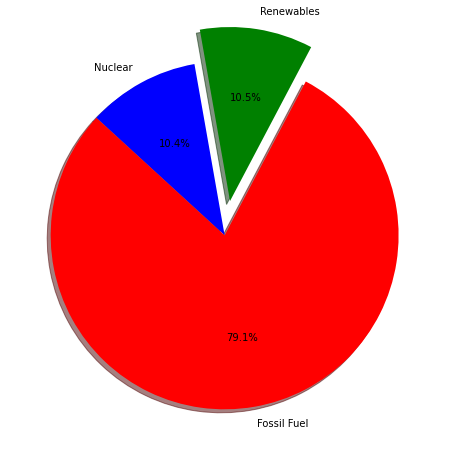

In [340]:
# Labels for the sections of our pie chart
labels = ["Nuclear", "Fossil Fuel", "Renewables"]

nuclear = main_sources['Nuclear'].sum()
fossil_fuel = main_sources['Fossil Fuel'].sum()
renewable = main_sources['Renewable'].sum()

# The values of each section of the pie chart
sizes = [nuclear, fossil_fuel, renewable]

# The colors of each section of the pie chart
colors = ["blue", "red", "green"]

# Tells matplotlib to seperate the "Humans" section from the others
explode = (0, 0, 0.2)
plt.subplots(figsize=(16, 8))
# Creates the pie chart based upon the values above
# Automatically finds the percentages of each part of the pie chart
plt.pie(sizes,explode=explode,  labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=100)

plt.show()

# Correlation fossil fuel x renewable

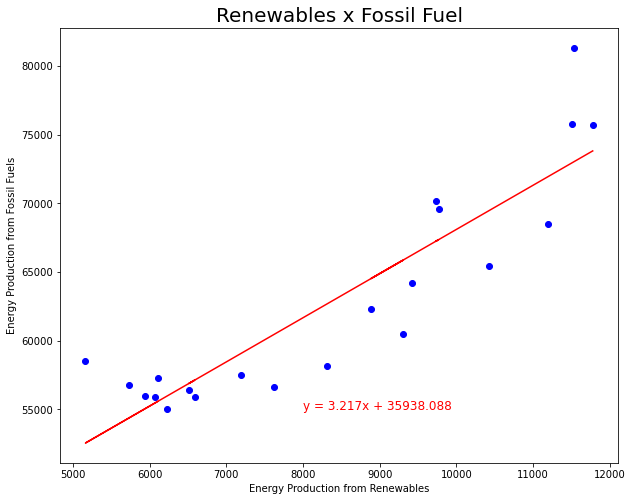

The r-squared is: 0.8019


In [341]:
# Calculate the correlation coefficient and linear regression model 
# for 
regress_values=[]
renewable = main_sources['Renewable']
fossil =  main_sources['Fossil Fuel']


plt.subplots(figsize=(10, 8))
(slope, intercept, rvalue, pvalue, stderr) = linregress(renewable, fossil)
regress_values = np.asarray(renewable) * slope + intercept
line_eq = "y = " + str(round(slope,3)) + "x + " + str(round(intercept,3))
plt.scatter(renewable, fossil,  color = 'blue')
plt.plot(renewable,regress_values,"r-")

plt.annotate(line_eq,(8000, 55000),fontsize=12,color="red")
plt.xlabel('Energy Production from Renewables')
plt.ylabel('Energy Production from Fossil Fuels')
plt.title('Renewables x Fossil Fuel',fontsize=20)
plt.show()
print(f"The r-squared is: {round(rvalue**2,4)}")

